Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [15]:
# %run -i "assignment_helper.py"
from helper import *
%matplotlib inline

# Probabilistic graphical models

Recall that probabilistic graphical models capture a compact representation of a joint probability distribution through conditionally independence: random variable $X$ is conditionally independent of $Y$ given $Z$ $(X\perp Y|Z)$, if $P(X=x, Y=y|Z=z) = P(X=x|Z=z)P(Y=y|Z=z)$ for all $x\in X,y\in Y,z\in Z$. A Markov network is a type of probabilistic graphical models that allows cycles in the graph and uses global normalization of probabilities (i.e. a partition function). The factorization of the joint probability distribution is given as a sum $P(X_1, \ldots, X_N) = \frac{1}{Z}\exp(-\sum_k E[C_k])$, where $C_k$ are are cliques of the graph, and $E[.]$ is an energy defined over the cliques.

**Exercise 1** (2 points). Define a Markov random field of four binary random variables in `dimod`. Random variables $X_1$ and $X_3$ are conditionally independent given $X_2$. The random variable $X_4$ is independent of all the other variables. The coupling strength on all edges in the graph is -1. Apart from the coupling between nodes, we also consider an external field of strength 1 applied to all nodes. Store the resulting `BinaryQuadraticModel` in an object called `model`.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import dimod


In [17]:

n_spins = 4
h = {v: 1 for v in range(n_spins)}
J = {(0, 1): -1,
     (1, 2): -1}
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.BINARY)
sampler = dimod.SimulatedAnnealingSampler()

In [18]:
assert isinstance(model, dimod.binary_quadratic_model.BinaryQuadraticModel)
assert model.vartype == dimod.BINARY
assert len(model.variables) == 4
assert [i for i in model.linear] == [0, 1, 2, 3]
assert [i for i in model.linear.values()] == [1, 1, 1, 1]
assert [i for i in model.quadratic] == [(0, 1), (1, 2)] or [i for i in model.quadratic] == [(1, 0), (2, 1)]
assert [i for i in model.quadratic.values()] == [-1, -1]

**Exercise 2** (2 points). Convert the `dimod` model to a `networkx` graph. Store it in an object called `G`. You can use the `add_nodes_from` and `add_edges_from` methods of the graph object and the `linear` and `quadratic` methods of the model object to construct the graph.

In [24]:
import networkx as nx

In [29]:
G = dimod.to_networkx_graph(model)

In [27]:
assert list(G.nodes) == [0, 1, 2, 3]
assert list(G.edges) == [(0,1), (1, 2)]

Now you can easily plot the Markov network:

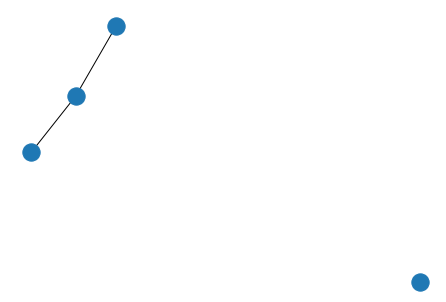

In [28]:
nx.draw(G)

**Exercise 3** (1 point). If we want to use quantum annealing to draw samples, we have to address the connectivity structure on the chip. Embed the graph on a single Chimera cell using `minorminer`.

In [34]:
import dwave_networkx  as dnx
import minorminer

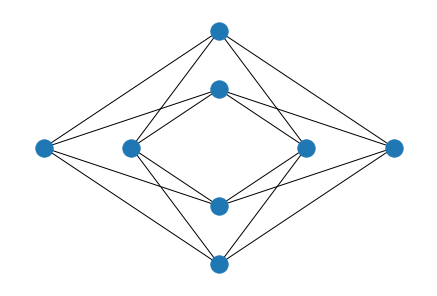

In [35]:
connectivity_structure = dnx.chimera_graph(1, 1)
dnx.draw_chimera(connectivity_structure)
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

In [36]:
assert isinstance(embedded_graph, dict)
assert len(embedded_graph) == 3

This is a very simple Markov network that does not need multiple physical qubits to represent a logical qubit. Note that the independent random variable $X_4$ does not appear in the embedding.

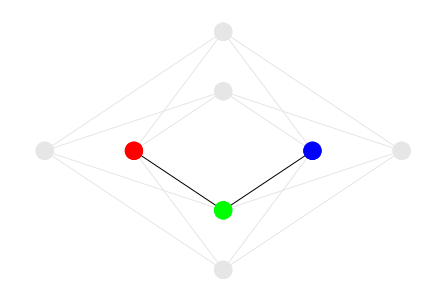

In [37]:
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
plt.show()

**Exercise 4** (2 points). Estimate the partition function of this model at temperature $T=1$ from 100 samples. Store the value in a variable called `Z`.

In [38]:
T = 1
Z = 0

In [40]:
response = sampler.sample(model, beta_range=[1/T, 1/T], num_reads=100)
response.aggregate()

SampleSet(rec.array([([0, 0, 1, 0], 1., 11), ([0, 1, 0, 1], 2.,  5),
           ([0, 0, 0, 1], 1.,  6), ([1, 1, 0, 0], 1., 15),
           ([0, 0, 0, 0], 0., 18), ([1, 1, 0, 1], 2.,  3),
           ([1, 1, 1, 0], 1.,  9), ([1, 0, 0, 1], 2.,  3),
           ([0, 1, 0, 0], 1.,  7), ([1, 0, 0, 0], 1.,  4),
           ([0, 0, 1, 1], 2.,  3), ([1, 0, 1, 1], 3.,  2),
           ([0, 1, 1, 1], 2.,  2), ([0, 1, 1, 0], 1.,  8),
           ([1, 0, 1, 0], 2.,  2), ([1, 1, 1, 1], 2.,  2)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i4')]), Variables([0, 1, 2, 3]), {}, 'BINARY')

In [43]:
g = {} # dictionary that associate to each energy E the degeneracy g[E]
for solution in response.aggregate().data():
    if solution.energy not in g.keys():
        g[solution.energy] = 0
    g[solution.energy] += 1
print("Degeneracy", g)
probabilities = np.array([g[E] * np.exp(-E/T) for E in g.keys()])
Z = probabilities.sum()
Z

Degeneracy {0.0: 1, 1.0: 7, 2.0: 7, 3.0: 1}


4.572290139224249

In [44]:
np.array([np.exp(-s.energy/T) for s in response.aggregate().data()]).sum()

4.572290139224249

With these components in hand, you can start building a quantum-enhanced sampler for Markov networks.